In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.set_printoptions(precision=3)
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import scale, StandardScaler

## Load data and explore

In [2]:
df = pd.read_csv('lending-club-data.csv', low_memory=False)

In [3]:
df.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'is_inc_v', 'issue_d',
       'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title',
       'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'policy_code', 'not_compliant', 'status', 'inactive_loans', 'bad_loans',
       'emp_length_num', 'grade_num', 'sub_gra

In [4]:
features = ['grade', 'sub_grade', 'short_emp', 'emp_length_num', 'home_ownership',
    'dti', 'purpose', 'term', 'last_delinq_none', 'last_major_derog_none',
    'revol_util', 'total_rec_late_fee']
df2 = df[features].dropna()
df2.head()

,grade,sub_grade,short_emp,emp_length_num,home_ownership,dti,purpose,term,last_delinq_none,last_major_derog_none,revol_util,total_rec_late_fee
0,B,B2,0.0,11.0,RENT,27.65,credit_card,36 months,1.0,1.0,83.7,0.00
1,C,C4,1.0,1.0,RENT,1.00,car,60 months,1.0,1.0,9.4,0.00
2,C,C5,0.0,11.0,RENT,8.72,small_business,36 months,1.0,1.0,98.5,0.00
3,C,C1,0.0,11.0,RENT,20.00,other,36 months,0.0,1.0,21.0,16.97
4,A,A4,0.0,4.0,RENT,11.20,wedding,36 months,1.0,1.0,28.3,0.00


In [5]:
df2['short_emp'] = df2['short_emp'].astype(np.int8)
df2['last_delinq_none'] = df2['last_delinq_none'].astype(np.int8)
df2['last_major_derog_none'] = df2['last_major_derog_none'].astype(np.int8)

In [6]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 61015 entries, 0 to 61014
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   grade                  61015 non-null  object 
 1   sub_grade              61015 non-null  object 
 2   short_emp              61015 non-null  int8   
 3   emp_length_num         61015 non-null  float64
 4   home_ownership         61015 non-null  object 
 5   dti                    61015 non-null  float64
 6   purpose                61015 non-null  object 
 7   term                   61015 non-null  object 
 8   last_delinq_none       61015 non-null  int8   
 9   last_major_derog_none  61015 non-null  int8   
 10  revol_util             61015 non-null  float64
 11  total_rec_late_fee     61015 non-null  float64
dtypes: float64(4), int8(3), object(5)
memory usage: 4.8+ MB


In [7]:
loan_counts = df['bad_loans'].value_counts(normalize=True) * 100

print(f"Safe Loans (0): {loan_counts.get(0, 0):.2f}%")
print(f"Risky Loans (1): {loan_counts.get(1, 0):.2f}%")

Safe Loans (0): 82.52%
Risky Loans (1): 17.48%


## Sample data to balance classes

In [8]:
safe_loans_raw = df[df['bad_loans'] == 0]
risky_loans_raw = df[df['bad_loans'] == 1]

In [9]:
# Since there are fewer risky loans than safe loans, find the ratio of the sizes and use that percentage to undersample the safe loans.
percentage = len(risky_loans_raw)/float(len(safe_loans_raw))
risky_loans = risky_loans_raw
safe_loans = safe_loans_raw.sample(frac = percentage, random_state = 1)

# Append the risky_loans with the downsampled version of safe_loans
loans_data = pd.concat([risky_loans, safe_loans], ignore_index=True)
loans_data

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,sub_grade_num,delinq_2yrs_zero,pub_rec_zero,collections_12_mths_zero,short_emp,payment_inc_ratio,final_d,last_delinq_none,last_record_none,last_major_derog_none
0,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,...,0.8,1.0,1.0,1.0,1.0,2.39320,20161201T000000,1.0,1.0,1.0
1,1071795,1306957,5600.0,5600.0,5600.0,60 months,21.28,152.39,F,F2,...,0.4,1.0,1.0,1.0,0.0,4.57170,20161201T000000,1.0,1.0,1.0
2,1071570,1306721,5375.0,5375.0,5350.0,60 months,12.69,121.45,B,B5,...,1.0,1.0,1.0,1.0,1.0,9.71600,20161201T000000,1.0,1.0,1.0
3,1064687,1298717,9000.0,9000.0,9000.0,36 months,13.49,305.38,C,C1,...,0.2,1.0,1.0,1.0,1.0,12.21520,20141201T000000,1.0,1.0,1.0
4,1069057,1303503,10000.0,10000.0,10000.0,36 months,10.65,325.74,B,B2,...,0.4,1.0,1.0,1.0,0.0,3.90888,20141201T000000,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21325,9815256,11667322,17000.0,17000.0,17000.0,60 months,15.61,409.90,C,C4,...,0.8,1.0,1.0,1.0,0.0,6.14850,20181201T000000,0.0,1.0,1.0
21326,6548871,8100956,16000.0,16000.0,16000.0,60 months,15.22,382.49,C,C3,...,0.6,1.0,1.0,1.0,0.0,7.75226,20180801T000000,1.0,1.0,1.0
21327,6316162,4671703,2200.0,2200.0,2200.0,36 months,13.05,74.18,B,B5,...,1.0,1.0,1.0,1.0,0.0,1.36948,20160701T000000,1.0,1.0,1.0
21328,521621,674547,25000.0,15625.0,15561.0,60 months,10.99,339.65,B,B4,...,0.8,1.0,1.0,1.0,0.0,5.50784,20150601T000000,1.0,1.0,1.0


In [10]:
loan_counts2 = loans_data['bad_loans'].value_counts(normalize=True) * 100

print(f"Percentage of Safe Loans (0): {loan_counts2.get(0, 0):.2f}%")
print(f"Percentage of Risky Loans (1): {loan_counts2.get(1, 0):.2f}%")

Percentage of Safe Loans (0): 50.00%
Percentage of Risky Loans (1): 50.00%


## Splitting the data

In [11]:
X=loans_data[features]
y=loans_data['bad_loans']

In [12]:
from sklearn.model_selection import train_test_split
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.1, random_state=0, stratify=loans_data['bad_loans'])
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2, random_state=0, stratify= y_trainval)

## One Hot Encoding

In [13]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from scipy import sparse

In [14]:
#encoding for decision tree
categorical_cols = ['grade', 'sub_grade', 'home_ownership', 'purpose', 'term','short_emp','last_delinq_none','last_major_derog_none']
num_cols= [x for x in features if x not in categorical_cols]
encoder = OneHotEncoder(drop='first', sparse_output=False)
X_train_er = encoder.fit_transform(X_train[categorical_cols])
X_val_er = encoder.transform(X_val[categorical_cols])
X_test_er = encoder.transform(X_test[categorical_cols])

scaler=StandardScaler()
X_train_scaled= scaler.fit_transform(X_train[num_cols])
X_val_scaled= scaler.transform(X_val[num_cols])
X_test_scaled= scaler.transform(X_test[num_cols])

#combining with num columns
X_train_num = sparse.csr_matrix(X_train_scaled)
X_val_num = sparse.csr_matrix(X_val_scaled)
X_test_num = sparse.csr_matrix(X_test_scaled)
X_train_en = sparse.hstack((X_train_er, X_train_num))
X_val_en = sparse.hstack((X_val_er, X_val_num))
X_test_en = sparse.hstack((X_test_er, X_test_num))

# Build a MLP classifier
Use 5-fold GridSearchCV on the train-validate set. Build a MLP classifier and based on accuracy
compare hyperparameters in the following grid:
hidden_layer_sizes: [(10,), (50,), (100,), (10, 10), (50, 50)]
Report the best model (call it MODEL1)’s accuracy, precision, recall, F1-score, balanced
accuracy, ROC-AUC on the test set. Plot the precision-recall curve and the ROC curve.
Will you choose a different model (call it MODEL2) if the GridSearchCV comparison was based
on ROC-AUC? Why?

In [15]:
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

In [16]:
col_trans=make_column_transformer((StandardScaler(), num_cols),(OneHotEncoder(drop='first', sparse_output=False), categorical_cols))

In [17]:
pipe1=make_pipeline(col_trans,MLPClassifier(solver='lbfgs', random_state=0,max_iter=10000))

In [18]:
param_grid= {'mlpclassifier__hidden_layer_sizes': [(10,), (50,), (100,), (10, 10), (50, 50)]} #(neurons_layer1,neurons_layer2,neurons_layer3...)

In [20]:
grid1 = GridSearchCV(
    pipe1,
    param_grid=param_grid,
    cv=5,
    return_train_score=True,
    scoring='accuracy',
    n_jobs=-1,

)


In [21]:


# Sample the data
X_train_sample = X_train.sample(n=10000, random_state=0)
y_train_sample = y_train.loc[X_train_sample.index]

grid1.fit(X_train_sample, y_train_sample)
print(f"Best score from GridSearchCV: {grid1.best_score_}")
print(f"Best parameters from GridSearchCV: {grid1.best_params_}")


Best score from GridSearchCV: 0.639
Best parameters from GridSearchCV: {'mlpclassifier__hidden_layer_sizes': (10,)}


Accuracy: 0.6357243319268636
Precision: 0.6331797235023041
Recall: 0.6444652908067542
F1-score: 0.6387726638772664
Balanced Accuracy: 0.6357284279713247
ROC-AUC: 0.6794021919744826


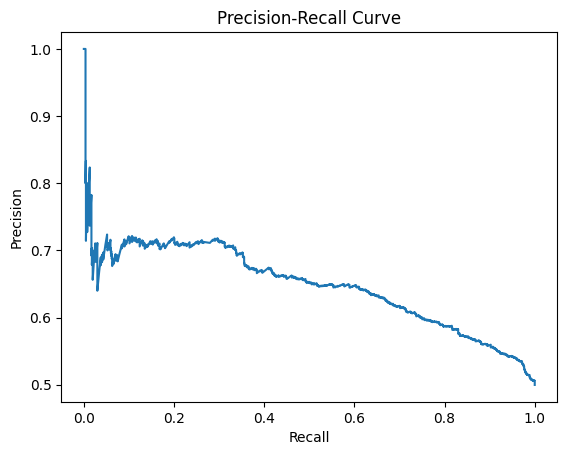

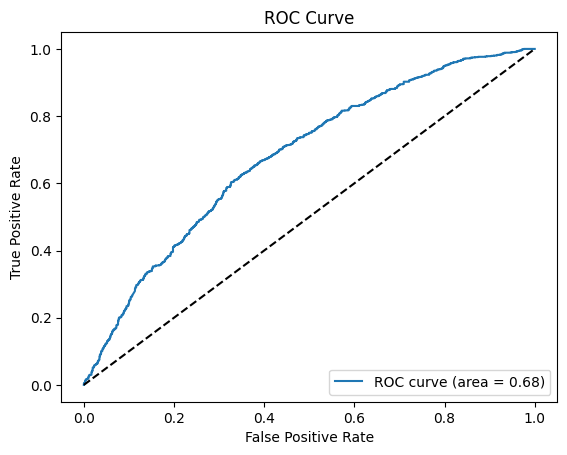

In [23]:


import matplotlib.pyplot as plt

# Get the best model
MODEL1 = grid1.best_estimator_

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score, roc_auc_score, precision_recall_curve, roc_curve, auc

# Predict on the test set
y_pred = MODEL1.predict(X_test)
y_prob = MODEL1.predict_proba(X_test)[:, 1]

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
print(f"Balanced Accuracy: {balanced_accuracy}")
print(f"ROC-AUC: {roc_auc}")

# Plot Precision-Recall Curve
precision_curve, recall_curve, thresholds = precision_recall_curve(y_test, y_prob)
plt.plot(recall_curve, precision_curve)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


#### Will you choose a different model (call it MODEL2) if the GridSearchCV comparison was based on ROC-AUC? Why?



Yes,  if the comparison is made on ROC-AUC a different model (MODEL2) *might* be preferred, especially if the class distribution is imbalanced which it is in this case.  


In [24]:

grid2 = GridSearchCV(
    pipe1,
    param_grid=param_grid,
    cv=5,
    return_train_score=True,
    scoring='roc_auc',
    n_jobs=-1,
)

# Sample the data
X_train_sample = X_train.sample(n=10000, random_state=0)
y_train_sample = y_train.loc[X_train_sample.index]

grid2.fit(X_train_sample, y_train_sample)
print(f"Best score from GridSearchCV: {grid1.best_score_}")
print(f"Best parameters from GridSearchCV: {grid1.best_params_}")

Best score from GridSearchCV: 0.639
Best parameters from GridSearchCV: {'mlpclassifier__hidden_layer_sizes': (10,)}


MODEL2 Metrics:
Accuracy: 0.6357243319268636
Precision: 0.6331797235023041
Recall: 0.6444652908067542
F1-score: 0.6387726638772664
Balanced Accuracy: 0.6357284279713247
ROC-AUC: 0.6794021919744826


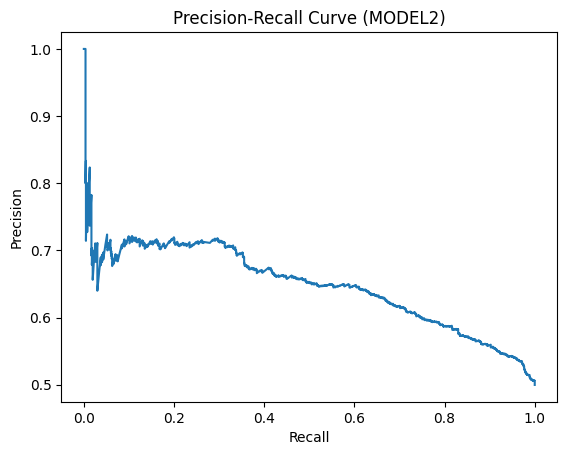

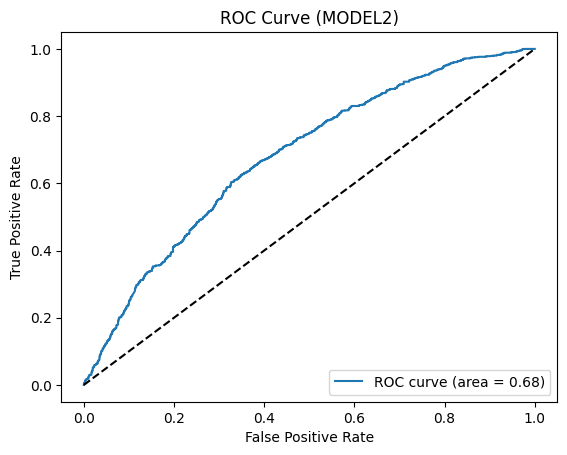

In [25]:

# Get the best model
MODEL2 = grid2.best_estimator_

# Predict on the test set
y_pred2 = MODEL2.predict(X_test)
y_prob2 = MODEL2.predict_proba(X_test)[:, 1]

# Calculate metrics for MODEL2
accuracy2 = accuracy_score(y_test, y_pred2)
precision2 = precision_score(y_test, y_pred2)
recall2 = recall_score(y_test, y_pred2)
f1_2 = f1_score(y_test, y_pred2)
balanced_accuracy2 = balanced_accuracy_score(y_test, y_pred2)
roc_auc2 = roc_auc_score(y_test, y_prob2)

print("MODEL2 Metrics:")
print(f"Accuracy: {accuracy2}")
print(f"Precision: {precision2}")
print(f"Recall: {recall2}")
print(f"F1-score: {f1_2}")
print(f"Balanced Accuracy: {balanced_accuracy2}")
print(f"ROC-AUC: {roc_auc2}")

# Plot Precision-Recall Curve for MODEL2
precision_curve2, recall_curve2, thresholds2 = precision_recall_curve(y_test, y_prob2)
plt.plot(recall_curve2, precision_curve2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (MODEL2)')
plt.show()

# Plot ROC Curve for MODEL2
fpr2, tpr2, thresholds2 = roc_curve(y_test, y_prob2)
roc_auc2 = auc(fpr2, tpr2)
plt.plot(fpr2, tpr2, label=f'ROC curve (area = {roc_auc2:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (MODEL2)')
plt.legend(loc="lower right")
plt.show()



# Quantifying the cost of mistakes

In [40]:
from sklearn.metrics import confusion_matrix
predictions = MODEL2.predict(X_test)


In [58]:

confusion_matrix(y_test, predictions)

array([[669, 398],
       [379, 687]])

In [59]:
false_positive2 = 398
false_negative2 = 370
true_positive2 = 687
true_negative2 = 669

In [57]:
cost_of_mistakes = true_positive + false_positive



In [56]:
cost_of_mistakes

1085

## Finally, compute the cost of mistakes made by the model by adding up the costs of true positives and false positives.
Let's assume that each mistake costs us money: a false negative costs 10,000 dollars, while a false
positive costs 20,000 dollars . What is the total cost of mistakes made by MODEL1 and MODEL2 on
the test data?

In [41]:
model2_mistakes = (10000 * false_negative) + (20000 * false_positive)

In [42]:
print('Model 2 - total cost of mistakes:',model2_mistakes)

Model 2 - total cost of mistakes: 11750000


In [45]:
predictions1 = MODEL1.predict(X_test)

In [46]:
confusion_matrix(y_test, predictions1)

array([[669, 398],
       [379, 687]])

In [48]:
false_positive1 = 398
false_negative1 = 379
true_positive2 = 687
true_negative2 = 669

In [49]:
MODEL1_mistakes = (10000 * false_negative1) + (20000 * false_positive1)

In [52]:
print('MODEL1 - total cost of mistakes:',MODEL1_mistakes)

MODEL1 - total cost of mistakes: 11750000


The total cost of mistakes for model 2 is greater than model 1

# Optional Question
Can you find another MLP classifier that generates a lower total cost of mistakes?

In [ ]:
from itertools import product

params_list= [(10,), (50,), (100,), (10, 10), (50, 50)]
activation=['relu','tanh']
best_model = None
lowest_cost = float('inf')  # Start with a very high cost
best_config = None

In [ ]:
for i,n in product(params_list, activation):
    pipe=make_pipeline(col_trans,MLPClassifier(solver='adam', max_iter=10000, hidden_layer_sizes=i, activation=n))
    model=pipe.fit(X_trainval,y_trainval)
    pred=model.predict(X_test)
    fp=np.sum((y_test==0)&(pred==1))
    fn=np.sum((y_test==1)&(pred==0))
    total_cost=fn*10000+fp*20000
    print('The model with {} layer and activation function of {} has a cost of mistakes of {}'.format(i,n,total_cost))

The model with (10,) layer and activation function of relu has a cost of mistakes of 2340000
The model with (10,) layer and activation function of tanh has a cost of mistakes of 2660000
The model with (50,) layer and activation function of relu has a cost of mistakes of 2850000
The model with (50,) layer and activation function of tanh has a cost of mistakes of 2770000
The model with (100,) layer and activation function of relu has a cost of mistakes of 2990000
The model with (100,) layer and activation function of tanh has a cost of mistakes of 2960000
The model with (10, 10) layer and activation function of relu has a cost of mistakes of 2420000
The model with (10, 10) layer and activation function of tanh has a cost of mistakes of 2720000
The model with (50, 50) layer and activation function of relu has a cost of mistakes of 2960000
The model with (50, 50) layer and activation function of tanh has a cost of mistakes of 2910000


The model with (10,) layer and activation function of relu using adam solver has the lowest cost of mistakes out of tested models of 23,400,000, which will be a good model to lower cost of mistakes
